In [1]:
import seaborn as sb
sb.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})
sb.set_context(rc={'lines.markeredgewidth': 1})

## Fitting upper limit of RV amplitude

In [2]:
# https://exofop.ipac.caltech.edu/tess/target.php?id=470381900
Porb = 2.50071474655903, 0.000511482
tc = 2458816.697706, 0.0027523146

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def phase_fold(time, rv_val, rv_err, P, tc=0):
    
    fold = (time-tc) % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

In [4]:
import pandas as pd

fp = "../data/rv/TOI1696_rv_all.dat"
df = pd.read_csv(fp,
#                  skiprows=[1] # <------------------first datapoint is 243 d apart from rest!
                )
df['rv'] = df['rv']*1000
df['rv_err'] = df['rv_err']*1000
df

,bjd,rv,rv_err
0,2.459245e+06,-81.987,8.17
1,2.459488e+06,46.578,7.02
2,2.459508e+06,57.321,9.29
3,2.459508e+06,25.829,7.04
4,2.459510e+06,63.226,8.91
5,2.459510e+06,0.000,7.32
6,2.459515e+06,-14.359,8.18
7,2.459515e+06,-29.625,7.20
8,2.459531e+06,-79.214,8.25


In [5]:
#first data points is 243 days apart from the rest
df.bjd.diff()

0           NaN
1    243.066250
2     19.961093
3      0.149916
4      1.825067
5      0.170287
6      4.860434
7      0.198360
8     15.721695
Name: bjd, dtype: float64

## test dataset
* uncomment below to test RV model

<AxesSubplot:xlabel='bjd'>

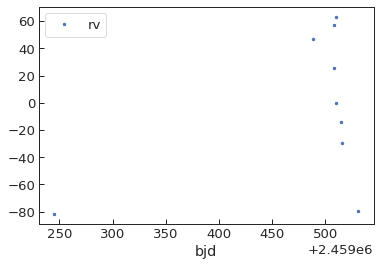

In [6]:
df.plot(x='bjd',y='rv',marker='.',ls='')

<ErrorbarContainer object of 3 artists>

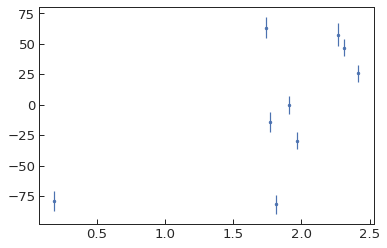

In [7]:
phase_time, phase_rv_val, phase_rv_err = phase_fold(df.bjd.values, 
                                                    df.rv.values, 
                                                    df.rv_err.values, 
                                                    P=Porb[0],
                                                    tc=tc[0]+Porb[0]/2
                                                   ) 
plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.')

## periodogram

In [8]:
import pandas as pd
import astropy.units as u
from astropy.timeseries import LombScargle

In [9]:
ls = LombScargle(df['bjd'], df['rv'])

In [10]:
# frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
frequency, power = ls.autopower(minimum_frequency=1/5, maximum_frequency=2)
period = 1/frequency

In [11]:
best_period = period[np.argmax(power)]
best_period

1.9970100087167897

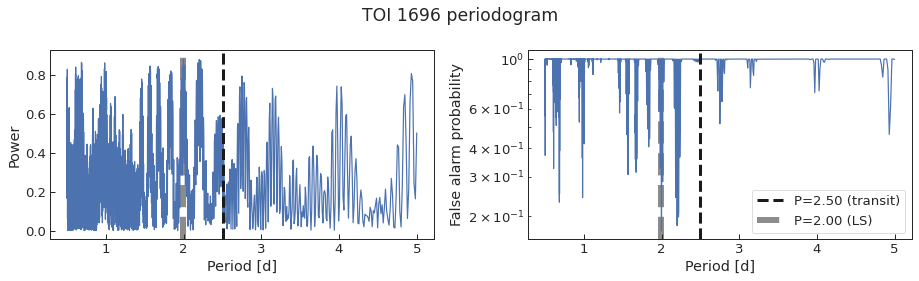

In [12]:
target = 'TOI 1696'

fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(Porb[0], 0, 1, ls='--', lw=3, c='k', label=f"P={Porb[0]:.2f} (transit)") for ax in axs]
[ax.axvline(best_period, c='k', ls='--', zorder=-1, lw=6, alpha=0.5, label=f"P={best_period:.2f} (LS)") for ax in axs]
plt.legend()
plt.setp(axs, xlabel='Period [d]')
plt.setp(axs[0], ylabel='Power')
plt.setp(axs[1], ylabel='False alarm probability')
fig.suptitle(f'{target} periodogram')
fig.tight_layout()

Periodogram cannot detect the period from transit

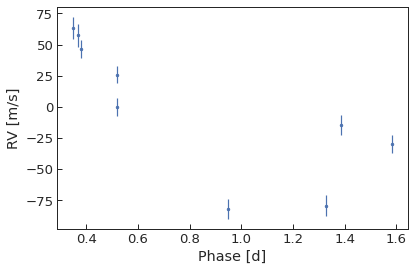

In [13]:
fig, ax = plt.subplots()
ax.errorbar(df['bjd'] % best_period, df['rv'], df['rv_err'], fmt='.')
plt.setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## LPF

In [14]:
from pytransit.lpf.rvlpf import RVLPF

lpf = RVLPF(target, 
            nplanets=1, 
            times=df['bjd'].values,#*u.day, 
            rvs=df['rv'].values,#*u.m/u.second, 
            rves=df['rv_err'].values,#*u.m/u.second
           )
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

In [15]:
# offset = Porb[0]/2
# lpf.set_prior('tc_1', 'NP', tc[0]+offset, tc[1]+offset)  
lpf.set_prior('tc_1', 'NP', 0, 1)
lpf.set_prior('p_1', 'NP', *Porb)
lpf.set_prior('rv_k_1', 'UP', 0.0, 500)        # main parameter of interest
lpf.set_prior('rv_shift_0', 'NP', 0, 10)   # unknown
lpf.set_prior('rv_err_0', 'NP', 0.0, 1)       # jitter term, NP assuming quoted rv err is not underestimated
lpf.set_prior('rv_slope', 'NP', 0, 0.1)        # essentially fixed
lpf.set_prior('secw_1', 'NP', 0, 0.01)         # essentially fixed, omega=ecc=0
lpf.set_prior('sesw_1', 'NP', 0, 0.01)         # essentially fixed
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 2.50071474655903, σ = 0.000511482) [    0.00 ..      inf],
   2 |G| secw_1         N(μ = 0.0, σ = 0.01)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         N(μ = 0.0, σ = 0.01)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 500)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]]

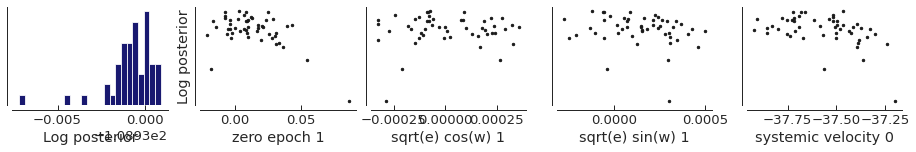

In [16]:
lpf.optimize_global(2000)

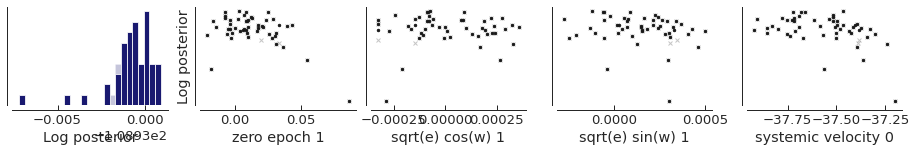

In [17]:
lpf.optimize_global(500)

In [44]:
lpf.rvm.rv_model??

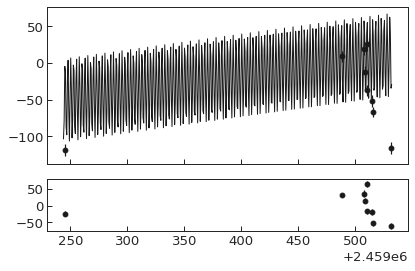

In [18]:
fig = lpf.plot_rv_vs_time(method='de')

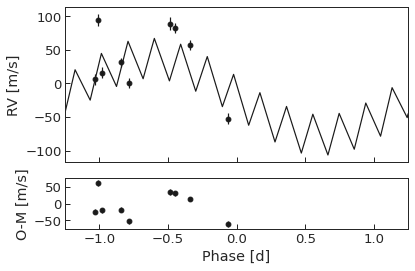

In [32]:
fig = lpf.plot_rv_vs_phase(planet=0, method='de', ntimes=500);

## mcmc

In [33]:
lpf.sample_mcmc(niter=5000, thin=10, repeats=2)

## posterior model

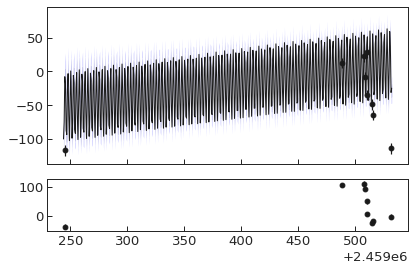

In [42]:
fig = lpf.plot_rv_vs_time(method='mcmc');

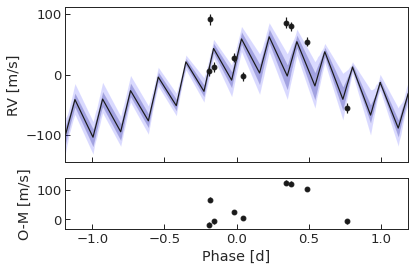

In [43]:
fig = lpf.plot_rv_vs_phase(planet=0, method='mcmc', ntimes=500)
# fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

## RV amplitude upper limit

In [23]:
df2 = lpf.posterior_samples()
df2['tc_1'] = lpf._tref
df2

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,2.459481e+06,2.500362,-0.002312,0.012655,-33.457335,8.627287,49.129730,0.210372
1,2.459481e+06,2.500362,-0.002312,0.012655,-33.457335,8.627287,49.129730,0.210372
2,2.459481e+06,2.500362,-0.002312,0.012655,-33.457335,8.627287,49.129730,0.210372
3,2.459481e+06,2.500362,-0.002312,0.012655,-33.457335,8.627287,49.129730,0.210372
4,2.459481e+06,2.500362,-0.002312,0.012655,-33.457335,8.627287,49.129730,0.210372
...,...,...,...,...,...,...,...,...
24995,2.459481e+06,2.501018,0.000523,-0.010248,-43.698112,8.266876,69.519072,0.170824
24996,2.459481e+06,2.500954,0.006385,-0.008063,-42.517811,8.004131,67.319247,0.168306
24997,2.459481e+06,2.500331,-0.004408,-0.009591,-36.060486,6.933850,55.070788,0.175119
24998,2.459481e+06,2.500331,-0.004408,-0.009591,-36.060486,6.933850,55.070788,0.175119


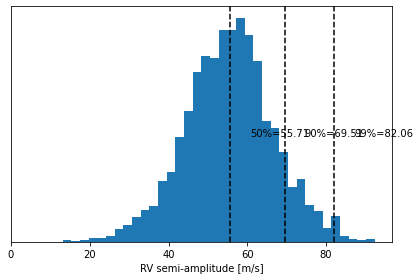

In [24]:
fig, ax = plt.subplots()
ax.hist(df2.rv_k_1, bins=40)
# ax.axvline(np.median(df2.rv_k_1), c='k')
pctls = [50,90,99]
vals = np.percentile(df2.rv_k_1, pctls)
for p,v in zip(pctls,vals):
    ax.axvline(v, 0, 1, ls='--', c='k')
    ax.text(v+5, 1000,f"{p}%={v:.2f}")
plt.setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

In [25]:
lpf.ps.names

['tc_1',
 'p_1',
 'secw_1',
 'sesw_1',
 'rv_shift_0',
 'rv_err_0',
 'rv_k_1',
 'rv_slope']

In [48]:
HALF_PI = 0.5 * np.pi
TWO_PI = 2 * np.pi

def secw(e, w):
    return np.sqrt(e)*cos(w)

def sesw(e, w):
    return np.sqrt(e)*sin(w)

def ecc(secw, sesw):
    return secw**2+sesw**2

def omega(sesw, secw):
    return np.arctan2(sesw, secw)

def rv_model(t, t0, p, e, w, k):    
    """
    M = 2*np.pi/P * (t - tp)
    E = E_sol(e, M)

    f = 2*np.arctan(((1+e)/(1-e))**0.5 * np.tan(E/2))

    rv = K*( np.cos(f)*np.cos(pomega) - np.sin(f)*np.sin(pomega) + gamma + e*np.cos(pomega))
    """
    ta = ta_newton_v(t, t0, p, e, w)
    rv = k * (np.cos(w + ta) + e * np.cos(w))
    return rv
    
def ta_newton_v(t, t0, p, e, w):
    """
    """
    Ma = mean_anomaly(t, t0, p, e, w)
    Ea = Ma.copy()
    for j in range(len(t)):
        err = 0.05
        k = 0
        while abs(err) > 1e-8 and k<1000:
            err   = Ea[j] - e*np.sin(Ea[j]) - Ma[j]
            Ea[j] = Ea[j] - err/(1.0-e*np.cos(Ea[j]))
            k += 1
    
    sta = np.sqrt(1.0-e**2) * np.sin(Ea)/(1.0-e*np.cos(Ea))
    cta = (np.cos(Ea)-e)/(1.0-e*np.cos(Ea))
    
    return np.arctan2(sta, cta)

def mean_anomaly(t, t0, p, e, w):
    offset = mean_anomaly_offset(e, w)
    Ma = np.mod(TWO_PI * (t - (t0 - offset * p / TWO_PI)) / p, TWO_PI)
    return Ma

def mean_anomaly_offset(e, w):
    mean_anomaly_offset = np.arctan2(np.sqrt(1.0-e**2) * np.sin(HALF_PI - w), e + np.cos(HALF_PI - w))
    mean_anomaly_offset -= e*np.sin(mean_anomaly_offset)
    return mean_anomaly_offset

In [49]:
df2 = lpf.posterior_samples()
df2['tc_1'] = lpf._tref
df2['ecc'] = ecc(df2['secw_1'], df2['sesw_1'])
df2['omega'] = np.rad2deg(omega(df2['secw_1'], df2['sesw_1']))
df2.median()

tc_1          2.459481e+06
p_1           2.499961e+00
secw_1       -4.610496e-04
sesw_1       -2.580208e-04
rv_shift_0   -3.464997e+01
rv_err_0     -7.076505e+00
rv_k_1        5.337637e+01
rv_slope      2.201863e-01
ecc           1.486654e-04
omega        -4.499630e+00
dtype: float64

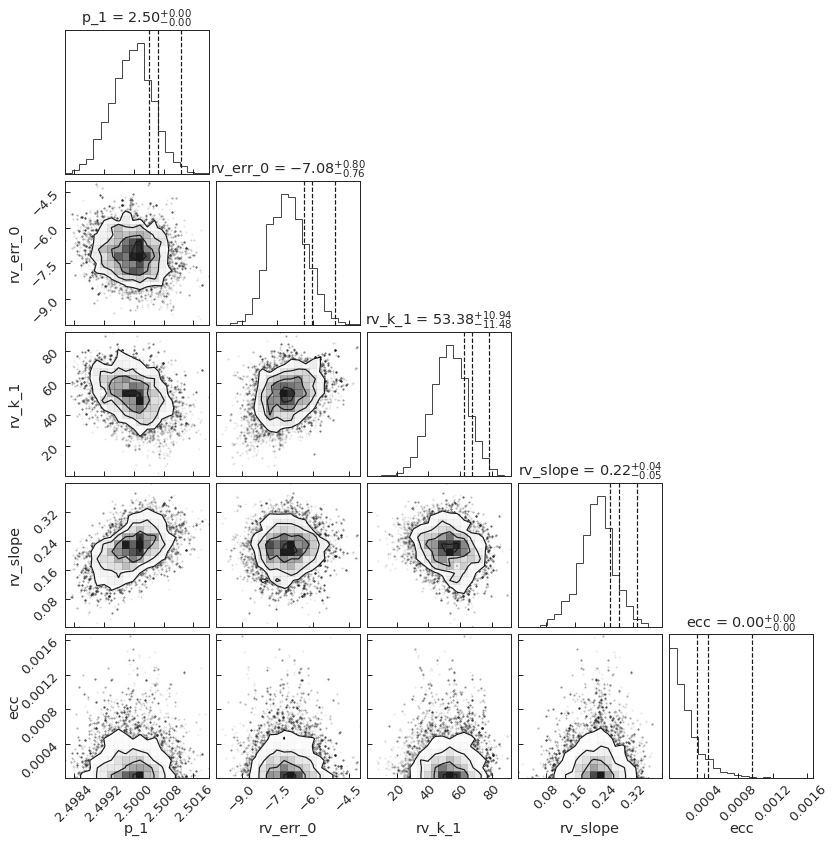

In [50]:
from corner import corner

plt.rcParams['font.size'] = 14

cols = 'p_1 rv_err_0 rv_k_1 rv_slope ecc'.split()
fig = corner(df2[cols], labels=cols, show_titles=True, quantiles=[0.80,0.90,0.99]);

In [51]:
pv = df2.median().values
pv

array([ 2.45948107e+06,  2.49996147e+00, -4.61049582e-04, -2.58020825e-04,
       -3.46499729e+01, -7.07650514e+00,  5.33763739e+01,  2.20186295e-01,
        1.48665366e-04, -4.49962986e+00])

In [52]:
t0=pv[0]
p=pv[1]
k=pv[6]
e=ecc(pv[2],pv[3])
w=omega(pv[2],pv[3])

N=500
t=np.linspace(df.bjd.min(),df.bjd.max(),N)
rv = rv_model(t, t0, p, e, w, k)
rv[:10]

array([  8.22319848,  53.3608147 ,   5.6683663 , -51.88516503,
       -19.17575327,  46.89310296,  31.38353074, -38.72293176,
       -41.46439105,  27.92843967])

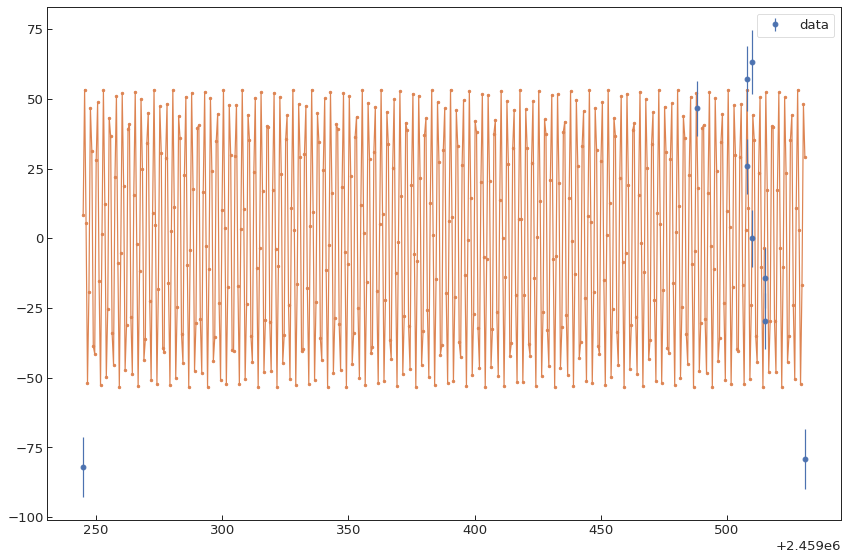

In [53]:
fig, ax = plt.subplots(figsize=(12,8))

rve = np.sqrt(df['rv_err']**2+pv[5]**2)
ax.errorbar(df['bjd'], df['rv'], rve, fmt='o', label='data', zorder=10)
plt.plot(t, rv, '.-')
plt.legend()
fig.tight_layout()

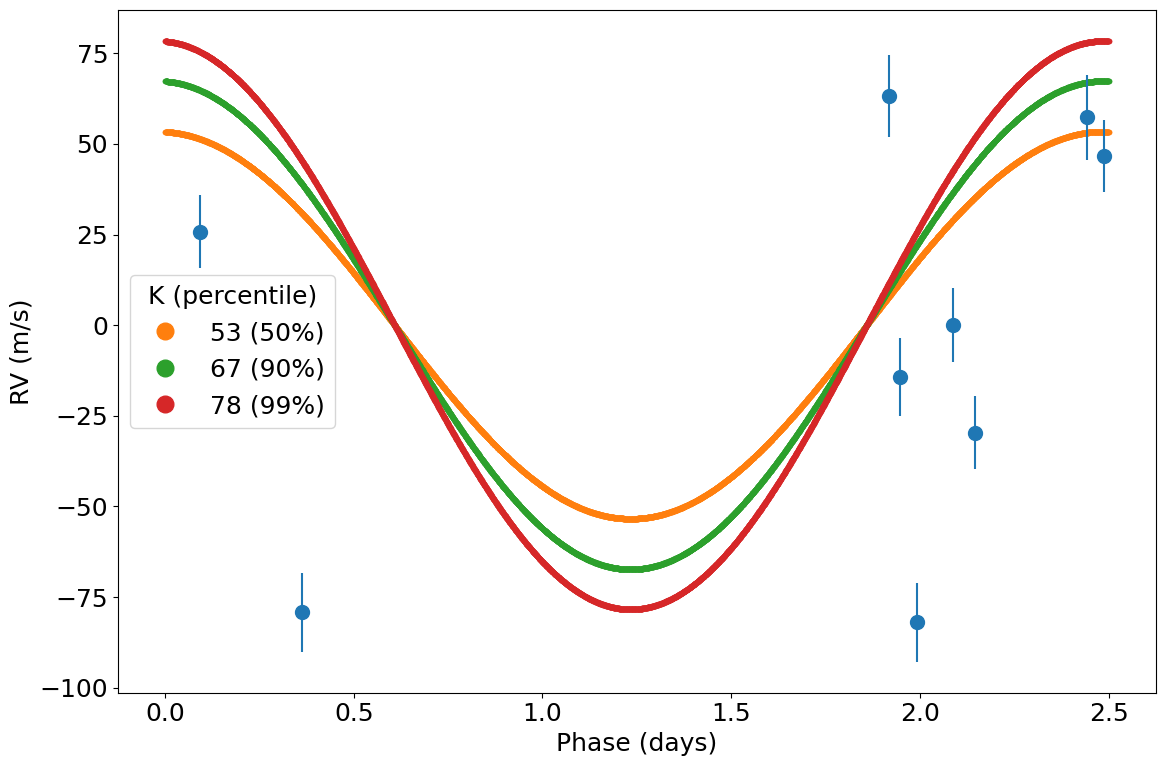

In [54]:
plt.style.use('default')
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12,8))

N = 5000
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase = t % Porb[0]
idx = np.argsort(phase)
ax.errorbar(df['bjd'] % Porb[0], df['rv'], rve, fmt='o', ms=10, zorder=10)

pctls = [50,90,99]
ks = np.percentile(df2.rv_k_1, pctls)
for k,i in zip(ks, pctls):
    rv = rv_model(t, t0, Porb[0], e, w, k)
    ax.plot(phase[idx], rv[idx], '.', label=f'{k:.0f} ({i}%)')
    
plt.legend(title='K (percentile)', markerscale=4)
plt.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)')
fig.tight_layout()

In [55]:
import astropy.units as u
import astropy.constants as c
from uncertainties import unumpy
import matplotlib.pyplot as pl

Mstar = (0.255, 0.007)
Mp = (10,1)
Ms_samples = np.random.rand(N)*Mstar[1]+Mstar[0]
mp_samples = np.ones_like(Ms_samples)
Porb_samples = np.random.rand(N)*Porb[1]+Porb[0]
inc_samples = np.ones_like(Ms_samples)*90

Kmax = (df2.rv_k_1.max()-df2.rv_k_1.min())/2
K_samples = np.random.uniform(df2.rv_k_1.std(), Kmax, len(Ms_samples))
e_samples = np.random.uniform(0, 0.01, len(Ms_samples))

In [56]:
def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=e_samples, inc=inc_samples):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

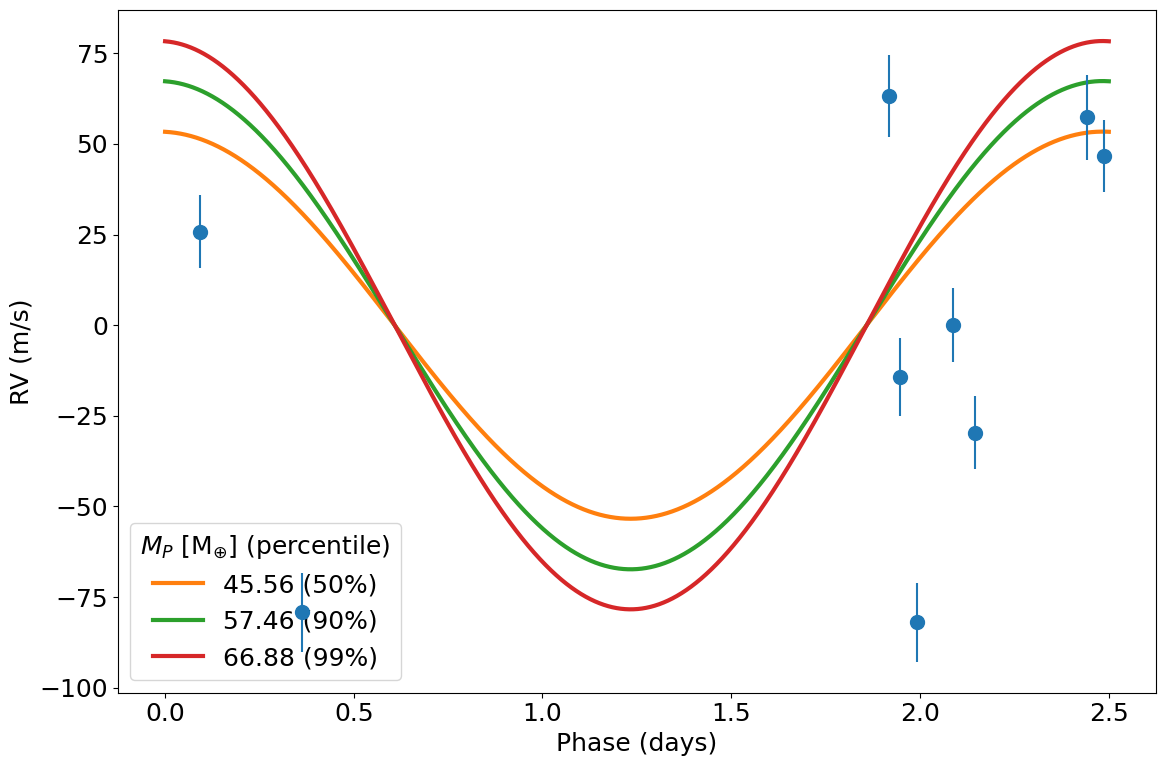

In [57]:
plt.style.use('default')
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12,8))

N = 5000
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase = t % Porb[0]
idx = np.argsort(phase)
ax.errorbar(df['bjd'] % Porb[0], df['rv'], rve, fmt='o', ms=10, zorder=10)

pctls = [50,90,99]
ks = np.percentile(df2.rv_k_1, pctls)
for i,k in zip(pctls,ks):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(t, t0, Porb[0], e, w, k)
    ax.plot(phase[idx], rv[idx], '-', lw=3, label=f'{Mp:.2f} ({i}%)')
plt.legend(title='$M_P$ [M$_{\oplus}$] (percentile)', markerscale=4, loc='lower left')
plt.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)')
fig.tight_layout()